Notes for methods
- Location: included 50 US states plus Washington DC

Questions for methods:
- Should we exclude campaigns that do not have more detailed donation data?

### Import packages

In [1]:
import sqlite3
import pandas as pd
import json
from itertools import chain
from random import sample
import numpy as np
import os
from bs4 import BeautifulSoup
import string
import re
import xmltodict
from xml.etree import ElementTree as ET
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt
import zipcodes
import fasttext
from datetime import datetime

### Queries and functions for reference

In [ ]:
#Select random sample
#pd.read_sql_query("SELECT url, fund_name, fund_description FROM feed_tb WHERE id IN (SELECT id FROM feed_tb ORDER BY RANDOM() LIMIT 20)", conn)

#remove html tags, remove \xa0
#feed['desc'] = [' '.join(BeautifulSoup(x).findAll(text=True)).replace(u'\xa0', u' ') for x in feed['fund_description']]

### Query db

In [2]:
conn = sqlite3.connect("gfm.db")

In [3]:
donation = pd.read_sql_query("SELECT * FROM donation_tb", conn)

In [3]:
feed = pd.read_sql_query("SELECT url, current_amount, goal_amount, donation_count, created_at, city, postal_code, country FROM feed_tb", conn)

In [3]:
#feed = pd.read_sql_query("SELECT url, fund_description FROM feed_tb", conn)

In [4]:
feed = feed.drop_duplicates('url')

In [96]:
#scrape = pd.read_sql_query("SELECT * FROM scrape_tb", conn)

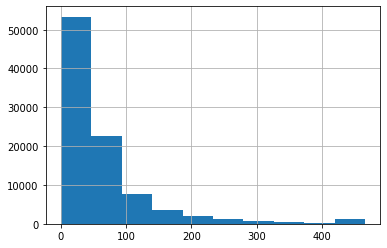

In [10]:
pd.Series(mstats.winsorize(feed['donation_count'], limits=[0.01,0.01])).hist()

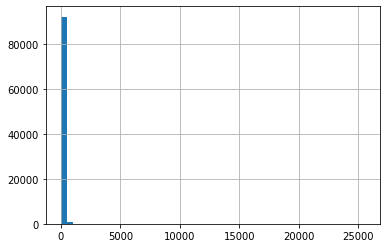

In [9]:
feed['donation_count'].hist(bins=50)

In [10]:
feed['donation_count'].describe()

count    92962.000000
mean        69.046675
std        192.516463
min          0.000000
25%         22.000000
50%         39.000000
75%         74.000000
max      25561.000000
Name: donation_count, dtype: float64

In [8]:
from scipy.stats import mstats

In [15]:
pd.Series(mstats.winsorize(feed['donation_count'], limits=[0.05,0.05])).describe()

count    92962.000000
mean        58.032121
std         53.381579
min          6.000000
25%         22.000000
50%         39.000000
75%         74.000000
max        209.000000
dtype: float64

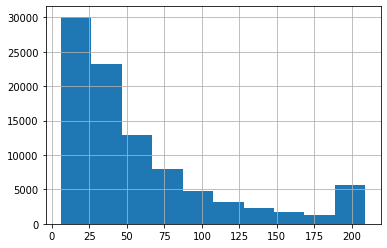

In [17]:
pd.Series(mstats.winsorize(feed['donation_count'], limits=[0.05,0.05])).hist()

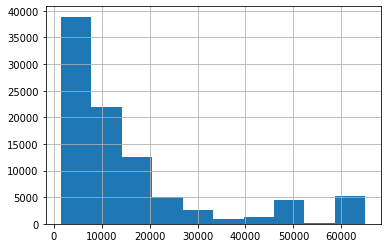

In [19]:
pd.Series(mstats.winsorize(feed['goal_amount'], limits=[0.05,0.05])).hist()

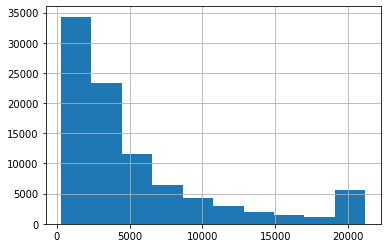

In [20]:
pd.Series(mstats.winsorize(feed['current_amount'], limits=[0.05,0.05])).hist()

In [43]:
feed.loc[:,'per_raised'] = feed['current_amount']/feed['goal_amount']

In [52]:
feed.loc[:,'goal_amount_winsor_5'] = mstats.winsorize(feed['goal_amount'], limits=[0.05,0.05])
feed.loc[:,'current_amount_winsor_5'] = mstats.winsorize(feed['current_amount'], limits=[0.05,0.05])
feed.loc[:,'per_raised_winsor_5'] = mstats.winsorize(feed['per_raised'], limits=[0.05,0.05])

feed.loc[:,'goal_amount_winsor_25'] = mstats.winsorize(feed['goal_amount'], limits=[0.025,0.025])
feed.loc[:,'current_amount_winsor_25'] = mstats.winsorize(feed['current_amount'], limits=[0.025,0.025])
feed.loc[:,'per_raised_winsor_25'] = mstats.winsorize(feed['per_raised'], limits=[0.025,0.025])

feed.loc[:,'goal_amount_winsor_1'] = mstats.winsorize(feed['goal_amount'], limits=[0.01,0.01])
feed.loc[:,'current_amount_winsor_1'] = mstats.winsorize(feed['current_amount'], limits=[0.01,0.01])
feed.loc[:,'per_raised_winsor_1'] = mstats.winsorize(feed['per_raised'], limits=[0.01,0.01])

In [56]:
feed[[
    'current_amount',
    'current_amount_winsor_5',
    'current_amount_winsor_25',
    'current_amount_winsor_1',
    'goal_amount',
    'goal_amount_winsor_5',
    'goal_amount_winsor_25',
    'goal_amount_winsor_1',
    'per_raised',
    'per_raised_winsor_5',
    'per_raised_winsor_25',
    'per_raised_winsor_1'
     ]
    ].describe().T

,count,mean,std,min,25%,50%,75%,max
current_amount,92962.0,6355.697909,1.539945e+04,0.0000,1835.0000,3250.000,6694.750,2.696160e+06
current_amount_winsor_5,92962.0,5343.919612,5.432615e+03,290.0000,1835.0000,3250.000,6694.750,2.116600e+04
current_amount_winsor_25,92962.0,5686.827306,6.610255e+03,50.0000,1835.0000,3250.000,6694.750,3.110000e+04
current_amount_winsor_1,92962.0,5957.412835,7.835497e+03,0.0000,1835.0000,3250.000,6694.750,4.824800e+04
goal_amount,92962.0,63426.235408,5.603087e+06,1.0000,5000.0000,10000.000,20000.000,1.000000e+09
goal_amount_winsor_5,92962.0,15577.528850,1.680943e+04,1500.0000,5000.0000,10000.000,20000.000,6.500000e+04
goal_amount_winsor_25,92962.0,17025.715002,2.179818e+04,1000.0000,5000.0000,10000.000,20000.000,1.000000e+05
goal_amount_winsor_1,92962.0,18333.323422,2.847310e+04,415.0000,5000.0000,10000.000,20000.000,2.000000e+05
per_raised,92962.0,26.825210,8.075358e+02,0.0000,0.1855,0.427,0.791,9.201300e+04
per_raised_winsor_5,92962.0,0.514361,3.866108e-01,0.0261,0.1855,0.427,0.791,1.360000e+00


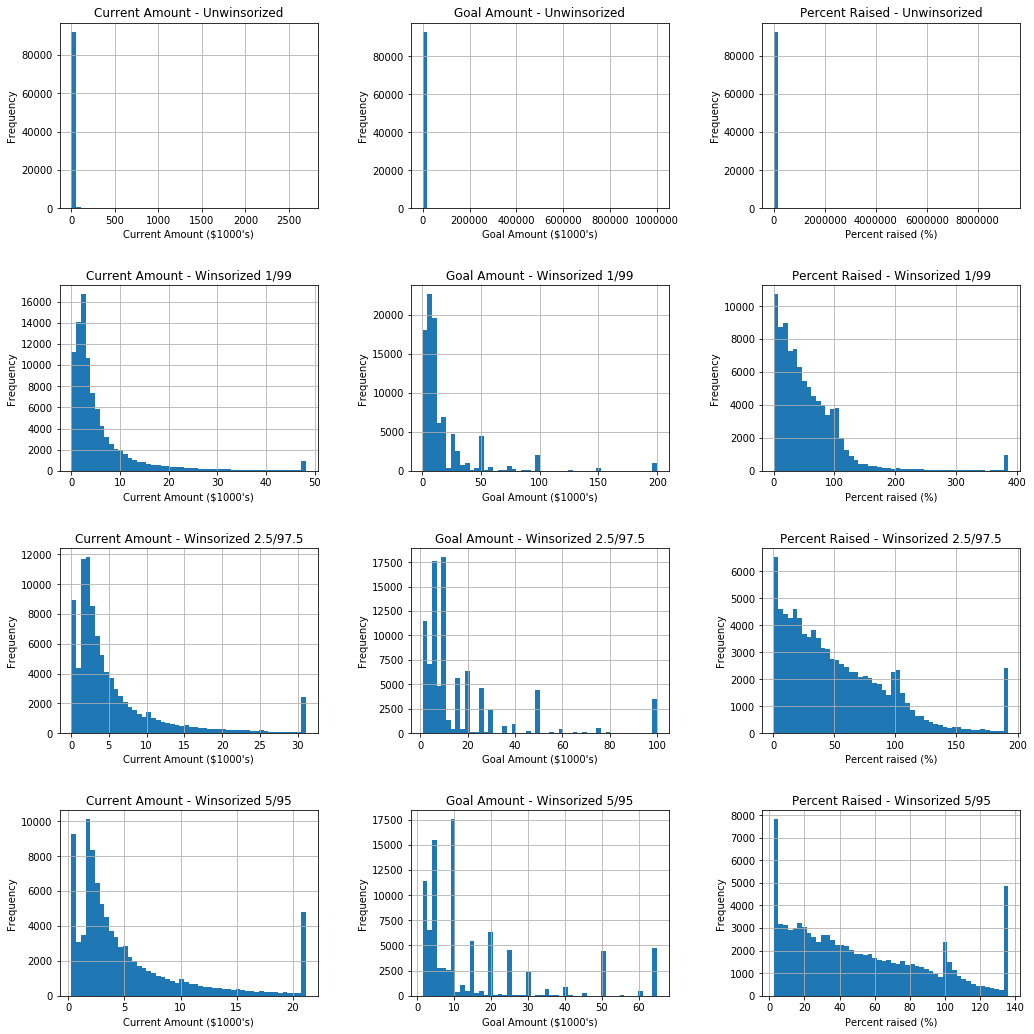

In [71]:
fig, axes = plt.subplots(4, 3, figsize=(15,15))

j = 1000

(feed['current_amount']/j).hist(bins=50, ax=axes[0,0])
axes[0,0].set_title('Current Amount - Unwinsorized')
axes[0,0].set_xlabel("Current Amount ($1000's)")
axes[0,0].set_ylabel("Frequency")

(feed['current_amount_winsor_1']/j).hist(bins=50, ax=axes[1,0])
axes[1,0].set_title('Current Amount - Winsorized 1/99')
axes[1,0].set_xlabel("Current Amount ($1000's)")
axes[1,0].set_ylabel("Frequency")

(feed['current_amount_winsor_25']/j).hist(bins=50, ax=axes[2,0])
axes[2,0].set_title('Current Amount - Winsorized 2.5/97.5')
axes[2,0].set_xlabel("Current Amount ($1000's)")
axes[2,0].set_ylabel("Frequency")

(feed['current_amount_winsor_5']/j).hist(bins=50, ax=axes[3,0])
axes[3,0].set_title('Current Amount - Winsorized 5/95')
axes[3,0].set_xlabel("Current Amount ($1000's)")
axes[3,0].set_ylabel("Frequency")

(feed['goal_amount']/j).hist(bins=50, ax=axes[0,1])
axes[0,1].set_title('Goal Amount - Unwinsorized')
axes[0,1].set_xlabel("Goal Amount ($1000's)")
axes[0,1].set_ylabel("Frequency")

(feed['goal_amount_winsor_1']/j).hist(bins=50, ax=axes[1,1])
axes[1,1].set_title('Goal Amount - Winsorized 1/99')
axes[1,1].set_xlabel("Goal Amount ($1000's)")
axes[1,1].set_ylabel("Frequency")

(feed['goal_amount_winsor_25']/j).hist(bins=50, ax=axes[2,1])
axes[2,1].set_title('Goal Amount - Winsorized 2.5/97.5')
axes[2,1].set_xlabel("Goal Amount ($1000's)")
axes[2,1].set_ylabel("Frequency")

(feed['goal_amount_winsor_5']/j).hist(bins=50, ax=axes[3,1])
axes[3,1].set_title('Goal Amount - Winsorized 5/95')
axes[3,1].set_xlabel("Goal Amount ($1000's)")
axes[3,1].set_ylabel("Frequency")

(feed['per_raised']*100).hist(bins=50, ax=axes[0,2])
axes[0,2].set_title('Percent Raised - Unwinsorized')
axes[0,2].set_xlabel("Percent raised (%)")
axes[0,2].set_ylabel("Frequency")

(feed['per_raised_winsor_1']*100).hist(bins=50, ax=axes[1,2])
axes[1,2].set_title('Percent Raised - Winsorized 1/99')
axes[1,2].set_xlabel("Percent raised (%)")
axes[1,2].set_ylabel("Frequency")

(feed['per_raised_winsor_25']*100).hist(bins=50, ax=axes[2,2])
axes[2,2].set_title('Percent Raised - Winsorized 2.5/97.5')
axes[2,2].set_xlabel("Percent raised (%)")
axes[2,2].set_ylabel("Frequency")

(feed['per_raised_winsor_5']*100).hist(bins=50, ax=axes[3,2])
axes[3,2].set_title('Percent Raised - Winsorized 5/95')
axes[3,2].set_xlabel("Percent raised (%)")
axes[3,2].set_ylabel("Frequency")

fig.tight_layout(pad=3.0)


# axes[0].set_title('SE')
# axes[1].set_title('CON1')
# axes[2].set_title('CON2')

# axes[0].set_xlabel("Goal Amount ($ millions)")
# axes[1].set_xlabel("Goal Amount ($ millions)")
# axes[2].set_xlabel("Goal Amount ($ millions)")

# axes[0].set_ylabel("Frequency")
# axes[1].set_ylabel("Frequency")
# axes[2].set_ylabel("Frequency")

In [75]:
pd.Series(feed['per_raised'] > 1).mean()

0.1437684215055614

In [73]:
13365/feed.shape[0]

0.1437684215055614

In [78]:
df = feed[['url','current_amount','goal_amount','created_at']]

In [79]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

In [80]:
missing_value_df

,column_name,percent_missing
url,url,0.0
current_amount,current_amount,0.0
goal_amount,goal_amount,0.0
created_at,created_at,0.0


In [85]:
import scipy
print(scipy.stats.spearmanr(feed['goal_amount_winsor_1'], feed['current_amount']))
print(scipy.stats.spearmanr(feed['donation_count'], feed['current_amount']))

SpearmanrResult(correlation=0.4956879112948479, pvalue=0.0)
SpearmanrResult(correlation=0.8759624677508121, pvalue=0.0)


In [88]:
from scipy import stats

F, p = stats.f_oneway(feed['current_amount'][feed['year'] == 2010], 
                      feed['current_amount'][feed['year'] == 2011], 
                      feed['current_amount'][feed['year'] == 2012],
                      feed['current_amount'][feed['year'] == 2013], 
                      feed['current_amount'][feed['year'] == 2014], 
                      feed['current_amount'][feed['year'] == 2015], 
                      feed['current_amount'][feed['year'] == 2016], 
                      feed['current_amount'][feed['year'] == 2017], 
                      feed['current_amount'][feed['year'] == 2018], 
                      feed['current_amount'][feed['year'] == 2019], 
                      feed['current_amount'][feed['year'] == 2020],
                     )

In [89]:
print(F)
print(p)

60.86435413443495
6.503800507086767e-124


## Data cleaning and defining new variables

### Cleaning time

In [86]:
feed['year'] = [x.split("-")[0] for x in feed['created_at']]

In [87]:
feed['year'] = feed['year'].astype(str).astype(int)

### Cleaning financial data

In [8]:
feed['per_raised'] = feed['current_amount']/feed['goal_amount']

In [9]:
feed['hit_goal'] = [0 if x < 1 else 1 for x in feed['per_raised']]

### Cleaning location

In [10]:
feed['city']

0           Kissimmee, FL
1            New York, NY
2            Prescott, AR
3          Woodbridge, VA
4             Alachua, FL
               ...       
99938        Gallatin, TN
99939         Lilburn, GA
99940     Saint Louis, MO
99941           Boone, IA
99942    Philadelphia, PA
Name: city, Length: 92962, dtype: object

It looks like the 'city' variable is in the form 'city, state'

So we will extract the state from the city variable

In [11]:
cities_split = [x.split(",") for x in feed['city']]

def getState(d):
    results = []
    for l in d:
        if(len(l)>1):
            results.append(l[1][1:])
        else:
            results.append("NO_STATE")
    return results

states = getState(cities_split)

In [12]:
pd.Series(states).value_counts().index

Index(['CA', 'TX', 'FL', 'NY', 'IL', 'GA', 'PA', 'WA', 'MI', 'NC', 'OH', 'AZ',
       'CO', 'VA', 'NJ', 'MN', 'MA', 'TN', 'OR', 'MO', 'IN', 'MD', 'WI', 'SC',
       'UT', 'LA', 'OK', 'AL', 'NV', 'CT', 'KY', 'KS', 'IA', 'AR', 'ID', 'ME',
       'NE', 'NM', 'NH', 'MT', 'MS', 'HI', 'NO_STATE', 'WV', 'AK', 'RI', 'SD',
       'ND', 'VT', 'DE', 'WY', 'PR', 'DC', 'GU', 'US', 'Florida', 'VI',
       'Minnesota', 'Oregon', 'Pa', 'Illinois', 'MP', 'Cincinnati', 'S',
       'New Hampshire', 'AS'],
      dtype='object')

Some states are not listed as abbreviations, so convert to abbreviations

In [13]:
def CleanStates(states):
    results = []
    for state in states:
        if state == "Minnesota":
            results.append('MN')
        elif state == "Florida":
            results.append('FL')
        elif state == "Oregon":
            results.append('OR')
        elif state == "Illinois":
            results.append('IL')
        elif state == "New Hampshire":
            results.append('NH')
        else:
            results.append(state)
    return results

states = CleanStates(states)

pd.Series(states).value_counts().index

Index(['CA', 'TX', 'FL', 'NY', 'IL', 'GA', 'PA', 'WA', 'MI', 'NC', 'OH', 'AZ',
       'CO', 'VA', 'NJ', 'MN', 'MA', 'OR', 'TN', 'MO', 'IN', 'MD', 'WI', 'SC',
       'UT', 'LA', 'OK', 'AL', 'NV', 'CT', 'KY', 'KS', 'IA', 'AR', 'ID', 'ME',
       'NE', 'NM', 'NH', 'MT', 'MS', 'HI', 'NO_STATE', 'WV', 'AK', 'RI', 'SD',
       'ND', 'VT', 'DE', 'WY', 'PR', 'DC', 'GU', 'US', 'VI', 'Pa', 'MP',
       'Cincinnati', 'S', 'AS'],
      dtype='object')

In [14]:
#add variable to rest of data to inspect
feed['state'] = states

Need to inspect these further:
- PR
- DC
- Pa
- MP
- Cincinnati
- S
- AS
- GU
- VI

In [15]:
feed[feed['state'].isin(['PR','DC'])]

,url,current_amount,goal_amount,donation_count,created_at,city,postal_code,country,year,per_raised,hit_goal,state
113,https://www.gofundme.com/f/1qz4jqekk0,497.0,3000.0,19,2019-09-09T07:22:34-05:00,"Arecibo, PR",614,US,2019,0.165667,0,PR
142,https://www.gofundme.com/f/pro-fondos-stephani...,910.0,10000.0,33,2019-06-14T10:55:30-05:00,"Vega Baja, PR",693,US,2019,0.091000,0,PR
157,https://www.gofundme.com/f/k7nz2-gastos-medico...,3144.0,15000.0,60,2019-02-22T18:59:31-06:00,"Ponce, PR",728,US,2019,0.209600,0,PR
770,https://www.gofundme.com/f/supportalexandra,5859.0,2500.0,79,2015-03-01T21:56:17-06:00,"Washington, DC",20005,US,2015,2.343600,1,DC
777,https://www.gofundme.com/f/e2q4wh-examenes-med...,725.0,500.0,14,2019-10-22T18:54:30-05:00,"Quebradillas, PR",678,US,2019,1.450000,1,PR
...,...,...,...,...,...,...,...,...,...,...,...,...
98402,https://www.gofundme.com/f/medical-supplies-fo...,1586.0,1000.0,41,2020-06-02T13:45:10-05:00,"Washington, DC",20007,US,2020,1.586000,1,DC
98691,https://www.gofundme.com/f/k4zq7w,3355.0,3000.0,48,2015-01-13T14:20:07-06:00,"Bayamon, PR",959,US,2015,1.118333,1,PR
98813,https://www.gofundme.com/f/9jsx3g7w,1920.0,7500.0,19,2016-03-06T14:21:48-06:00,"Vega Alta, PR",692,US,2016,0.256000,0,PR
99098,https://www.gofundme.com/f/kindness-for-michael,969.0,10000.0,29,2018-12-19T08:33:30-06:00,"Arecibo, PR",613,US,2018,0.096900,0,PR


In [16]:
feed[feed['state'].isin(['Pa','MP','Cincinnati','S','AS', 'VI'])]

,url,current_amount,goal_amount,donation_count,created_at,city,postal_code,country,year,per_raised,hit_goal,state
2250,https://www.gofundme.com/f/RAY-STRONG,5860.0,50000.0,79,2015-10-29T17:59:22-05:00,"Canonsburg, Pa, PA",15317,US,2015,0.117200,0,Pa
2695,https://www.gofundme.com/f/supporting-anson039...,2160.0,10000.0,30,2019-12-28T20:14:27-06:00,"St Thomas, VI",802,US,2019,0.216000,0,VI
4475,https://www.gofundme.com/f/ingrid039s-surgery-...,7045.0,10000.0,33,2020-08-06T14:43:12-05:00,"St Thomas, VI",802,US,2020,0.704500,0,VI
5242,https://www.gofundme.com/f/kikifire,10810.0,15000.0,95,2015-01-30T15:45:02-06:00,"Kingshill, VI",851,US,2015,0.720667,0,VI
5451,https://www.gofundme.com/f/h4729n6c,14065.0,10000.0,127,2015-10-24T11:27:59-05:00,"St Thomas, VI",801,US,2015,1.406500,1,VI
7078,https://www.gofundme.com/f/CaptainJay,7775.0,50000.0,59,2016-02-29T20:14:39-06:00,"St John, VI",831,US,2016,0.155500,0,VI
13335,https://www.gofundme.com/f/kevin-gilfoyle-fami...,5715.0,5000.0,60,2020-03-01T14:09:34-06:00,"Canonsburg, Pa, PA",15317,US,2020,1.143000,1,Pa
13414,https://www.gofundme.com/f/7s74xzjw,4670.0,10000.0,71,2015-10-25T17:55:14-05:00,"Saipan, MP",96950,US,2015,0.467000,0,MP
14211,https://www.gofundme.com/f/ayudemos-a-francisc...,1005.0,3000.0,24,2020-05-21T12:36:05-05:00,"Canonsburg, Pa, PA",15317,US,2020,0.335000,0,Pa
14844,https://www.gofundme.com/f/a-mother039s-tears,10141.0,150000.0,181,2018-08-20T07:19:32-05:00,"Saipan, MP",96950,US,2018,0.067607,0,MP


The following were inspected and zip codes were checked
- PR: Puerto Rico
- DC: Washington, DC
- Pa: Pennsylvania, seems to be coded strangely only for Canonsburg
- MP: Northern Mariana Islands
- Cincinnati: Ohio, seems to be coded strangely only for Colerain Township
- S: River Vale New Jersy
- AS: American Samoa
- GU: Guam
- VI: Virgin Islands

Will update cleaning function for Pa, Cincinnati, S

In [17]:
def CleanStates(states):
    results = []
    for state in states:
        if state == "Minnesota":
            results.append('MN')
        elif state == "Florida":
            results.append('FL')
        elif state == "Oregon":
            results.append('OR')
        elif state == "Illinois":
            results.append('IL')
        elif state == "New Hampshire":
            results.append('NH')
        elif state == "Pa":
            results.append('PA')
        elif state == "Cincinnati":
            results.append('OH')
        elif state == "S":
            results.append('NJ')
        else:
            results.append(state)
    return results

states = CleanStates(states)

pd.Series(states).value_counts().index

Index(['CA', 'TX', 'FL', 'NY', 'IL', 'GA', 'PA', 'WA', 'MI', 'NC', 'OH', 'AZ',
       'CO', 'VA', 'NJ', 'MN', 'MA', 'OR', 'TN', 'MO', 'IN', 'MD', 'WI', 'SC',
       'UT', 'LA', 'OK', 'AL', 'NV', 'CT', 'KY', 'KS', 'IA', 'AR', 'ID', 'ME',
       'NE', 'NM', 'NH', 'MT', 'MS', 'HI', 'NO_STATE', 'WV', 'AK', 'RI', 'SD',
       'ND', 'VT', 'DE', 'WY', 'PR', 'DC', 'GU', 'US', 'VI', 'MP', 'AS'],
      dtype='object')

In [18]:
#Update dataframe with new cleaned data
feed['state'] = states

Exclude Puerto Rico (PR), Northern Mariana Islands (MP), American Samoa (AS), Guam (GU), Virgin Islands (VI)

In [19]:
feed = feed[~feed['state'].isin(['PR','MP','AS','GU', 'VI'])]

Now investigate those with "NO_STATE"

In [20]:
feed[feed['state'] == 'NO_STATE']

,url,current_amount,goal_amount,donation_count,created_at,city,postal_code,country,year,per_raised,hit_goal,state
187,https://www.gofundme.com/f/brad039s-new-hope,45925.0,50000.0,479,2018-11-24T14:04:47-06:00,,"80528 - Fort Collins, CO",US,2018,0.918500,0,NO_STATE
366,https://www.gofundme.com/f/brandon-webster-hea...,9097.0,20000.0,107,2018-03-14T13:00:13-05:00,VA/DC/MD,22407,US,2018,0.454850,0,NO_STATE
1131,https://www.gofundme.com/f/please-help-me-get-...,365.0,5000.0,7,2019-01-16T14:29:31-06:00,,88010,US,2019,0.073000,0,NO_STATE
1370,https://www.gofundme.com/f/covid-19-funds-for-...,4065.0,5000.0,34,2020-03-19T19:36:43-05:00,,92048,US,2020,0.813000,0,NO_STATE
1407,https://www.gofundme.com/f/e5sw2h-post-surgery...,0.0,3500.0,0,2020-07-20T17:41:27-05:00,,85117,US,2020,0.000000,0,NO_STATE
...,...,...,...,...,...,...,...,...,...,...,...,...
99273,https://www.gofundme.com/f/savingatlas,1860.0,1860.0,28,2016-05-11T19:23:16-05:00,,16,US,2016,1.000000,1,NO_STATE
99371,https://www.gofundme.com/f/lexisrecovery,3160.0,3000.0,73,2016-06-23T20:44:08-05:00,,2,US,2016,1.053333,1,NO_STATE
99522,https://www.gofundme.com/f/jferrarotto,4440.0,20000.0,52,2016-02-22T21:11:05-06:00,,89158,US,2016,0.222000,0,NO_STATE
99857,https://www.gofundme.com/f/jincycancer,2135.0,2.0,22,2014-09-05T23:51:56-05:00,,,US,2014,1067.500000,1,NO_STATE


These data seem a little messy, but most have postal codes listed.

So we will run postal codes through a zipcode API to see if we can get states for these rows.

In [21]:
def ZipToState(codes):
    results = []
    for code in codes:
        try:
            r = zipcodes.matching(str(code))
            results.append(r[0]['state'])
        except:
            results.append('NO_STATE')
    return results

ZipToState(feed[feed['state'] == 'NO_STATE']['postal_code'])

['NO_STATE',
 'VA',
 'NO_STATE',
 'NO_STATE',
 'AZ',
 'NO_STATE',
 'CO',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'FL',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'FL',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'TX',
 'FL',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'VA',
 'NO_STATE',
 'MN',
 'NO_STATE',
 'TX',
 'NY',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'MO',
 'CO',
 'NO_STATE',
 'CO',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NM',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'VA',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'TX',
 'NO_STATE',
 'FL',
 'NO_STATE',
 'NO_STATE',
 'N

This finds a state for a small number.

This also introduces some additional non-US states, such as PR and AP.

We will go ahead and add in the states that we were able to find with this method.

In [22]:
feed.loc[feed['state'] == 'NO_STATE', 'state'] = ZipToState(feed[feed['state'] == 'NO_STATE']['postal_code'])

Next we will check the state codes again, explore what these are, and apply exclusions accordingly.

In [23]:
feed['state'].value_counts().index

Index(['CA', 'TX', 'FL', 'NY', 'IL', 'GA', 'PA', 'WA', 'MI', 'NC', 'OH', 'AZ',
       'CO', 'VA', 'NJ', 'MN', 'MA', 'OR', 'TN', 'MO', 'IN', 'MD', 'WI', 'SC',
       'UT', 'LA', 'OK', 'AL', 'NV', 'CT', 'KY', 'KS', 'IA', 'AR', 'ID', 'ME',
       'NE', 'NM', 'NH', 'MT', 'MS', 'HI', 'WV', 'AK', 'NO_STATE', 'RI', 'SD',
       'ND', 'VT', 'DE', 'WY', 'DC', 'US', 'AP', 'AA', 'PR'],
      dtype='object')

In [24]:
feed[feed['state'].isin(['US','AP','PR','AA','VI'])]

,url,current_amount,goal_amount,donation_count,created_at,city,postal_code,country,year,per_raised,hit_goal,state
2189,https://www.gofundme.com/f/FrancesCalhoun,4005.0,5000.0,67,2015-03-18T15:15:12-05:00,"APO, US",9464,US,2015,0.801000,0,US
7705,https://www.gofundme.com/f/224b393jc0,3790.0,7000.0,25,2020-07-01T22:28:57-05:00,"Green Brook, US",8812,US,2020,0.541429,0,US
8410,https://www.gofundme.com/f/odufdo,1775.0,10000.0,25,2015-03-09T22:00:27-05:00,"Green Brook, US",8812,US,2015,0.177500,0,US
10930,https://www.gofundme.com/f/j3338rzk,31061.0,50000.0,221,2015-08-31T07:33:10-05:00,"APO, US",9356,US,2015,0.621220,0,US
18780,https://www.gofundme.com/f/unexpected-dental-b...,310.0,5000.0,7,2019-12-25T05:44:45-06:00,"APO, US",96338,US,2019,0.062000,0,US
19901,https://www.gofundme.com/f/elizabeth-rodriguez...,1830.0,5000.0,16,2019-07-09T18:07:09-05:00,"Green Brook, US",8812,US,2019,0.366000,0,US
21867,https://www.gofundme.com/f/blesstheciannellos,15865.0,25000.0,173,2015-11-07T13:21:37-06:00,"Green Brook, US",8812,US,2015,0.634600,0,US
22243,https://www.gofundme.com/f/suzanne-weems-brain...,4500.0,4500.0,38,2017-09-26T16:31:32-05:00,"APO, US",9012,US,2017,1.000000,1,US
22668,https://www.gofundme.com/f/brandon-and-jessica...,2390.0,2000.0,30,2017-03-23T12:23:51-05:00,"APO, US",9128,US,2017,1.195000,1,US
27046,https://www.gofundme.com/f/e42gn-watkins-family,5808.0,4000.0,68,2018-02-01T22:16:20-06:00,FPO,96349,US,2018,1.452000,1,AP


In [25]:
feed = feed[~feed['state'].isin(['US','AP','PR','AA','VI'])]

Inspect data assigned NO_STATE again

In [26]:
#feed[feed['state'] == "NO_STATE"].to_csv("no_state.csv")

There are some zip codes in strings.

Extract integers from string then put through zipcode API to see if we can avoid excluding those.

In [27]:
def ZipCodeInt(codes):
    results = []
    for code in codes:
        try:
            code_int = [int(s) for s in code.split() if s.isdigit()][0]
            r = zipcodes.matching(str(code_int))
            results.append(r[0]['state'])
        except:
            results.append('NO_STATE')
    return results

ZipCodeInt(feed[feed['state'] == 'NO_STATE']['postal_code'])

['CO',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'AZ',
 'NO_STATE',
 'NO_STATE',
 'MI',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'FL',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'CA',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'NO_STATE',
 'N

This finds a few more states.

Will add these to the data.

In [28]:
feed.loc[feed['state'] == 'NO_STATE', 'state'] = ZipCodeInt(feed[feed['state'] == 'NO_STATE']['postal_code'])

In [29]:
feed['state'].value_counts().index

Index(['CA', 'TX', 'FL', 'NY', 'IL', 'GA', 'PA', 'WA', 'MI', 'NC', 'OH', 'AZ',
       'CO', 'VA', 'NJ', 'MN', 'MA', 'OR', 'TN', 'MO', 'IN', 'MD', 'WI', 'SC',
       'UT', 'LA', 'OK', 'AL', 'NV', 'CT', 'KY', 'KS', 'IA', 'AR', 'ID', 'ME',
       'NE', 'NM', 'NH', 'MT', 'MS', 'HI', 'WV', 'AK', 'RI', 'NO_STATE', 'SD',
       'ND', 'VT', 'DE', 'WY', 'DC'],
      dtype='object')

In [30]:
len(feed['state'].value_counts().index)

52

There are appropriately 52 categories in the state variable: 50 states + DC + NO_STATE

Now we will categorize into census regions

census regions were obtained from here: https://github.com/cphalpert/census-regions/blob/master/us%20census%20bureau%20regions%20and%20divisions.csv

In [31]:
census = pd.read_csv("census_regions.csv")

In [32]:
census.head()

,state,state_code,region,division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [33]:
feed = pd.merge(feed, census[['state_code', 'region']], left_on='state', right_on='state_code', how='left')

In [34]:
del feed['state_code']
feed.rename(columns={'region':'census_region'}, inplace=True)

In [35]:
feed.head()

,url,current_amount,goal_amount,donation_count,created_at,city,postal_code,country,year,per_raised,hit_goal,state,census_region
0,https://www.gofundme.com/f/Amarilindo,2340.0,10000.0,37,2016-02-16T08:42:39-06:00,"Kissimmee, FL",34743,US,2016,0.234000,0,FL,South
1,https://www.gofundme.com/f/m6gg66vd,2200.0,2300.0,45,2016-01-26T10:19:44-06:00,"New York, NY",10014,US,2016,0.956522,0,NY,Northeast
2,https://www.gofundme.com/f/2vhyamk,1640.0,5000.0,15,2016-10-22T10:02:54-05:00,"Prescott, AR",71857,US,2016,0.328000,0,AR,South
3,https://www.gofundme.com/f/support-loving-moth...,2370.0,5000.0,30,2019-09-09T17:07:36-05:00,"Woodbridge, VA",22193,US,2019,0.474000,0,VA,South
4,https://www.gofundme.com/f/Aeolis_Est,8790.0,2000.0,167,2016-06-03T20:59:55-05:00,"Alachua, FL",32615,US,2016,4.395000,1,FL,South


In [36]:
feed = feed[~feed['state'].isin(['NO_STATE'])]

### Add medicaid expansion data

Import medicaid expansion data from KFF, accessed 12/1/2020

In [37]:
medicaid = pd.read_csv('medicaid/KFF_expansion-status-interactive-map_10.1.20.csv')

In [38]:
medicaid.head()

,State,Expansion Status,Description
0,Alabama,Not Adopted,NaN
1,Alaska,Adopted and Implemented,Implemented expansion on 9/1/2015\n
2,Arizona,Adopted and Implemented,Implemented expansion on 1/1/2014\n
3,Arkansas,Adopted and Implemented,Implemented expansion on 1/1/2014 \n
4,California,Adopted and Implemented,Implemented expansion on 1/1/2014\n


Merge with census data to get state_code

In [39]:
medicaid = pd.merge(medicaid, census[['state_code', 'state']], left_on='State', right_on='state', how='left')

In [40]:
del medicaid['State']

In [41]:
medicaid.head()

,Expansion Status,Description,state_code,state
0,Not Adopted,NaN,AL,Alabama
1,Adopted and Implemented,Implemented expansion on 9/1/2015\n,AK,Alaska
2,Adopted and Implemented,Implemented expansion on 1/1/2014\n,AZ,Arizona
3,Adopted and Implemented,Implemented expansion on 1/1/2014 \n,AR,Arkansas
4,Adopted and Implemented,Implemented expansion on 1/1/2014\n,CA,California


In [42]:
date_regex = r'(0?\d|1[012])\/([012]?\d|3[01])\/\d{4}'

In [43]:
medicaid['date_expansion'] = [datetime.strptime(re.search(date_regex, x).group(0),'%m/%d/%Y') if x is not np.nan else np.nan for x in medicaid['Description']]

In [44]:
medicaid['Expansion Status'].value_counts()

Adopted and Implemented        37
Not Adopted                    12
Adopted but Not Implemented     2
Name: Expansion Status, dtype: int64

In [45]:
feed = pd.merge(feed, medicaid, left_on='state', right_on='state_code', how='left')

In [46]:
feed['created_at_date'] = [datetime.strptime(x.split("T")[0], '%Y-%m-%d') for x in feed['created_at']]

In [47]:
feed.head()

,url,current_amount,goal_amount,donation_count,created_at,city,postal_code,country,year,per_raised,hit_goal,state_x,census_region,Expansion Status,Description,state_code,state_y,date_expansion,created_at_date
0,https://www.gofundme.com/f/Amarilindo,2340.0,10000.0,37,2016-02-16T08:42:39-06:00,"Kissimmee, FL",34743,US,2016,0.234000,0,FL,South,Not Adopted,NaN,FL,Florida,NaT,2016-02-16
1,https://www.gofundme.com/f/m6gg66vd,2200.0,2300.0,45,2016-01-26T10:19:44-06:00,"New York, NY",10014,US,2016,0.956522,0,NY,Northeast,Adopted and Implemented,Implemented expansion on 1/1/2014\n,NY,New York,2014-01-01,2016-01-26
2,https://www.gofundme.com/f/2vhyamk,1640.0,5000.0,15,2016-10-22T10:02:54-05:00,"Prescott, AR",71857,US,2016,0.328000,0,AR,South,Adopted and Implemented,Implemented expansion on 1/1/2014 \n,AR,Arkansas,2014-01-01,2016-10-22
3,https://www.gofundme.com/f/support-loving-moth...,2370.0,5000.0,30,2019-09-09T17:07:36-05:00,"Woodbridge, VA",22193,US,2019,0.474000,0,VA,South,Adopted and Implemented,Expansion coverage implemented 1/1/2019 (enrol...,VA,Virginia,2019-01-01,2019-09-09
4,https://www.gofundme.com/f/Aeolis_Est,8790.0,2000.0,167,2016-06-03T20:59:55-05:00,"Alachua, FL",32615,US,2016,4.395000,1,FL,South,Not Adopted,NaN,FL,Florida,NaT,2016-06-03


In [48]:
def AddExpansionStatus(df):
    r = []
    for i in range(0, len(df)):
        if df.iloc[i]['Expansion Status'] == 'Adopted and Implemented':
            r.append(df.iloc[i]['date_expansion'] <= df.iloc[i]['created_at_date'])
        else:
            r.append(np.nan)
    return r

In [49]:
feed['post_expansion'] = AddExpansionStatus(feed)

In [50]:
feed['post_expansion'].value_counts()

True     54154
False     5885
Name: post_expansion, dtype: int64

In [51]:
feed['Expansion Status'].value_counts()

Adopted and Implemented        60039
Not Adopted                    29568
Adopted but Not Implemented     2758
Name: Expansion Status, dtype: int64

In [52]:
feed.head()

,url,current_amount,goal_amount,donation_count,created_at,city,postal_code,country,year,per_raised,hit_goal,state_x,census_region,Expansion Status,Description,state_code,state_y,date_expansion,created_at_date,post_expansion
0,https://www.gofundme.com/f/Amarilindo,2340.0,10000.0,37,2016-02-16T08:42:39-06:00,"Kissimmee, FL",34743,US,2016,0.234000,0,FL,South,Not Adopted,NaN,FL,Florida,NaT,2016-02-16,NaN
1,https://www.gofundme.com/f/m6gg66vd,2200.0,2300.0,45,2016-01-26T10:19:44-06:00,"New York, NY",10014,US,2016,0.956522,0,NY,Northeast,Adopted and Implemented,Implemented expansion on 1/1/2014\n,NY,New York,2014-01-01,2016-01-26,True
2,https://www.gofundme.com/f/2vhyamk,1640.0,5000.0,15,2016-10-22T10:02:54-05:00,"Prescott, AR",71857,US,2016,0.328000,0,AR,South,Adopted and Implemented,Implemented expansion on 1/1/2014 \n,AR,Arkansas,2014-01-01,2016-10-22,True
3,https://www.gofundme.com/f/support-loving-moth...,2370.0,5000.0,30,2019-09-09T17:07:36-05:00,"Woodbridge, VA",22193,US,2019,0.474000,0,VA,South,Adopted and Implemented,Expansion coverage implemented 1/1/2019 (enrol...,VA,Virginia,2019-01-01,2019-09-09,True
4,https://www.gofundme.com/f/Aeolis_Est,8790.0,2000.0,167,2016-06-03T20:59:55-05:00,"Alachua, FL",32615,US,2016,4.395000,1,FL,South,Not Adopted,NaN,FL,Florida,NaT,2016-06-03,NaN


In [53]:
feed.groupby('Expansion Status')['goal_amount'].mean()

Expansion Status
Adopted and Implemented        48344.111661
Adopted but Not Implemented    19556.283176
Not Adopted                    98917.523302
Name: goal_amount, dtype: float64

In [56]:
feed['Expansion Status'].value_counts()

Adopted and Implemented        60039
Not Adopted                    29568
Adopted but Not Implemented     2758
Name: Expansion Status, dtype: int64

### Time series plot

In [60]:
feed['created_at_date'] = pd.to_datetime(feed['created_at_date'])

In [61]:
feed = feed.sort_values('created_at_date')

In [80]:
df = feed[['created_at_date','goal_amount']]

In [81]:
df = df.set_index('created_at_date')

In [82]:
df = df.sort_index()

In [83]:
df.head()

,goal_amount
created_at_date,
2010-08-28,10000.0
2010-09-25,30000.0
2010-10-26,20000.0
2010-12-04,10000.0
2010-12-23,5000.0


In [90]:
df.groupby(df.index.date).mean()['goal_amount']

2010-08-28    10000.000000
2010-09-25    30000.000000
2010-10-26    20000.000000
2010-12-04    10000.000000
2010-12-23     5000.000000
                  ...     
2020-08-11    24452.819149
2020-08-12    74792.699422
2020-08-13    14863.188235
2020-08-14    11663.192308
2020-08-15     8500.000000
Name: goal_amount, Length: 2832, dtype: float64

In [50]:
#feed.to_csv('feed_medicaid.csv')

In [120]:
feed.groupby('post_expansion')['goal_amount'].mean()

post_expansion
False    21545.06763
True     51256.40575
Name: goal_amount, dtype: float64

In [123]:
feed.groupby('post_expansion')['current_amount'].mean()

post_expansion
False    6840.732031
True     6875.475884
Name: current_amount, dtype: float64

In [121]:
feed.groupby('Expansion Status')['goal_amount'].mean()

Expansion Status
Adopted and Implemented        48344.111661
Adopted but Not Implemented    19556.283176
Not Adopted                    98917.523302
Name: goal_amount, dtype: float64

In [143]:
feed.groupby('Expansion Status')['goal_amount'].std()

Expansion Status
Adopted and Implemented        4.213871e+06
Adopted but Not Implemented    6.491071e+04
Not Adopted                    7.915070e+06
Name: goal_amount, dtype: float64

In [157]:
asdf = feed[feed.goal_amount < feed.goal_amount.quantile(.995)]

In [158]:
asdf.groupby('Expansion Status')['goal_amount'].mean()

Expansion Status
Adopted and Implemented        17554.880814
Adopted but Not Implemented    16075.128962
Not Adopted                    17528.253596
Name: goal_amount, dtype: float64

### Donation data analysis

In [5]:
len(donation)

6693703

Lots of donations

In [6]:
donation.head()

,don_id,online_id,url,don_amt,don_offline,don_anon,don_name,don_date,don_profile,don_verified
0,1,75288239,https://www.gofundme.com/f/Amarilindo,10.0,0,0,Patrice Whitely,2016-03-13T16:09:18-05:00,,1
1,2,72701479,https://www.gofundme.com/f/Amarilindo,20.0,0,0,cheryl redman,2016-03-03T07:19:35-06:00,,1
2,3,72113923,https://www.gofundme.com/f/Amarilindo,25.0,0,0,Stephanie C,2016-03-01T08:44:25-06:00,,1
3,4,71698975,https://www.gofundme.com/f/Amarilindo,30.0,0,0,Tracy H,2016-02-28T12:22:35-06:00,,1
4,5,71101151,https://www.gofundme.com/f/Amarilindo,50.0,0,0,Yosh Takashima,2016-02-25T18:45:31-06:00,,1


Get date of latest donation for each url

In [64]:
latest_donation = donation.groupby('url', sort=True)['don_date'].max()
latest_donation_date = latest_donation.to_list()
url = latest_donation.index.tolist()
latest_donation_df = pd.DataFrame({'url':url, 'latest_donation_date':latest_donation_date})

In [69]:
feed = pd.merge(feed, latest_donation_df, on='url', how='left')

In [65]:
donation.url.nunique()

90954

In [66]:
len(latest_donation_df)

90954

In [67]:
sum(feed['donation_count'] == 0)

1989

It looks like there are several thousand campaigns for which we do not have donation data.

Will inspect a couple of these manually to see if this was a scraping problem.

In [99]:
feed.url.nunique()

92962

In [101]:
len(feed)

99943

In [102]:
feed.url.duplicated().any()

True

It looks like there are duplicate urls in the feed data.

Inspect these.

In [103]:
feed[feed.duplicated('url', keep=False)]

,url,current_amount,goal_amount,donation_count,created_at,city,postal_code,country,latest_donation_date
1,https://www.gofundme.com/f/m6gg66vd,2200.0,2300.0,45,2016-01-26T10:19:44-06:00,"New York, NY",10014,US,2016-04-27T06:02:18-05:00
7,https://www.gofundme.com/f/KatsLymeFund,5080.0,5000.0,58,2015-10-21T17:12:17-05:00,"Herndon, VA",20170,US,2015-10-28T17:48:30-05:00
16,https://www.gofundme.com/f/Bosephgreenwood,8970.0,20000.0,61,2016-05-11T11:17:04-05:00,"Victorville, CA",92395,US,2016-05-19T20:35:31-05:00
28,https://www.gofundme.com/f/x6kyt8,4400.0,5000.0,57,2015-06-16T20:26:39-05:00,"Willowbrook, IL",60527,US,2015-08-04T12:42:32-05:00
42,https://www.gofundme.com/f/mqu2qo,6205.0,10000.0,57,2015-02-18T21:42:54-06:00,"Surprise, AZ",85379,US,2015-07-24T12:14:26-05:00
...,...,...,...,...,...,...,...,...,...
99885,https://www.gofundme.com/f/MarkArchuletaJr,1660.0,10000.0,40,2016-08-25T09:17:18-05:00,"Albuquerque, NM",87109,US,2016-12-18T20:28:08-06:00
99897,https://www.gofundme.com/f/ea0kts,1635.0,6000.0,37,2014-09-09T18:23:01-05:00,"Belleville, MI",48111,US,2015-08-17T16:36:12-05:00
99900,https://www.gofundme.com/f/2nt563w,13344.0,1977.0,162,2016-09-07T20:21:32-05:00,"Kingston, PA",18704,US,2017-08-15T20:24:23-05:00
99931,https://www.gofundme.com/f/xs2u24g4,51436.0,25000.0,111,2015-08-25T07:02:39-05:00,"Ballston Spa, NY",12020,US,2017-01-30T04:30:33-06:00


Look at scrape record to see if these were scraped multiple times.

In [109]:
scrape[scrape['url'] == feed[feed.duplicated('url', keep=False)].url.unique()[3]]

,camp_id,url,resp_status,date_scrape,cat,target_cat,activity_status,country
222,223,https://www.gofundme.com/f/x6kyt8,200,"Thu, 20 Aug 2020 22:01:33 GMT",11.0,1.0,active,US
191395,191396,https://www.gofundme.com/f/x6kyt8,200,"Tue, 18 Aug 2020 08:44:58 GMT",11.0,1.0,active,US


It looks like these were scraped twice.

A few ideas why this may have happened:
- They were duplicated in the sitemap.
- They were part of the re-dos.

Will check sitemap data first.

In [110]:
sitemap = pd.read_csv('data_/sitemaps_combined.csv')

In [117]:
sitemap[sitemap['url'] == feed[feed.duplicated('url', keep=False)].url.unique()[3]]

,Unnamed: 0,url,last-mod
386774,36774,https://www.gofundme.com/f/x6kyt8,2016-06-28


It does not appear that there were duplicates in the sitemap.

So it is likely that these were scraped twice during re-dos from failed connections.

In [119]:
feed = feed.drop_duplicates('url')

In [123]:
feed.url.duplicated().any()

False

In [124]:
feed.duplicated().any()

False

There are no more duplicates.

In [135]:
feed[(feed['donation_count'] != 0) & (pd.isnull(feed['latest_donation_date']))]

,url,current_amount,goal_amount,donation_count,created_at,city,postal_code,country,latest_donation_date
6416,https://www.gofundme.com/f/qzd2e-respite-care,1630.0,2500.0,18,2020-02-28T16:27:20-06:00,"San Diego, CA",92117,US,NaN
6667,https://www.gofundme.com/f/help-ursula-get-peace,1550.0,20000.0,12,2018-06-06T07:32:40-05:00,"Fort Lauderdale, FL",33301,US,NaN
7518,https://www.gofundme.com/f/roclathon-2020,200.0,3000.0,7,2020-02-26T08:27:15-06:00,"Altoona, PA",16602,US,NaN
8335,https://www.gofundme.com/f/help-support-helen-...,600.0,50000.0,6,2020-02-21T09:36:11-06:00,"Woodbine, NJ",8270,US,NaN
8823,https://www.gofundme.com/f/hezkjg-it-takes-a-v...,1785.0,7000.0,30,2020-02-27T07:05:39-06:00,"Saint Cloud, FL",34769,US,NaN
10346,https://www.gofundme.com/f/5ru6y-hope-for-melanie,295.0,1000000.0,6,2020-02-11T13:36:38-06:00,"Huntsville, AR",72740,US,NaN
12710,https://www.gofundme.com/f/heart-sugery-for-mark,1850.0,30000.0,10,2018-08-06T10:07:14-05:00,"Saint Clair Shores, MI",48082,US,NaN
13241,https://www.gofundme.com/f/rainbows-for-sick-kids,260.0,1000.0,7,2020-02-21T15:46:07-06:00,"Madison, WI",53704,US,NaN
18151,https://www.gofundme.com/f/1xa5nb0iao,235.0,1200.0,9,2020-03-10T16:23:43-05:00,"Oklahoma City, OK",73129,US,NaN
18415,https://www.gofundme.com/f/jens-fight-for-a-ki...,228.0,25000.0,6,2020-02-23T20:33:57-06:00,"Hamilton, OH",45011,US,NaN


There are a small number of campaigns that have raised money but do not have corresponding donation data.

Upon manual inspection, it appears that these campaigns have some option where they don't display individual donations.

Here is an example
![example](no_donation_example.png)

### Excluding veterinary campaigns

In [2]:
conn = sqlite3.connect("gfm.db")
feed = pd.read_sql_query("SELECT url, fund_description FROM feed_tb", conn)
feed = feed.drop_duplicates('url')

In [3]:
feed = feed.drop_duplicates('url')
feed['fund_description'] = [' '.join(BeautifulSoup(x).findAll(text=True)).replace(u'\xa0', u' ') for x in feed['fund_description']]
feed['fund_description'] = feed['fund_description'].str.lower()

/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning: "b'/'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [4]:
def CountTerms(df, terms):
    '''
    input: pandas df of campaign descriptions, list of terms
    '''
    results = {}
    for term in terms:
        if type(term) == list:
            search_term_0 = r"\b{0}\b".format(term[0])
            search_term_1 = r"\b{0}\b".format(term[1])
            res_0 = np.array(df['fund_description'].str.contains(search_term_0).to_list())
            res_1 = np.array(df['fund_description'].str.contains(search_term_1).to_list())
            res_and = np.logical_and(res_0, res_1).astype(int).tolist()
            label = (" + ").join(term)
            results[label] = res_and
        else:
            search_term = r"\b{0}\b".format(term)
            results[term] = df['fund_description'].str.contains(search_term).astype(int).to_list()
    return results

In [68]:
vet = [
    'veterinary',
    'veterinarian',
    'vet',
    'dog',
    'cat',
    'puppy',
    'kitty',
    'pet',
]

vet = [
    ['pet','veterinary'],
    ['pet','veterinarian'],
    ['pet','vet'],
    ['dog','veterinary'],
    ['dog','veterinarian'],
    ['dog','vet'],
    ['service dog','veterinary'],
    ['service dog','veterinarian'],
    ['service dog','vet'],
    ['puppy','veterinary'],
    ['puppy','veterinarian'],
    ['puppy','vet'],
    ['kitty','veterinary'],
    ['kitty','veterinarian'],
    ['kitty','vet'],
    ['cat','veterinary'],
    ['cat','veterinarian'],
    ['cat','vet']
]



In [20]:
terms = ['lung cancer', 'smoker', 'smoke']

In [21]:
count_dict = CountTerms(feed, terms)

In [22]:
df = pd.concat([feed, pd.DataFrame(count_dict)], axis=1)

In [23]:
df = df[df['lung cancer'] == 1]

In [27]:
df['smoker'].value_counts()

0.0    1832
1.0      49
Name: smoker, dtype: int64

In [70]:
counts = pd.DataFrame(count_dict)

In [71]:
counts_sum = counts.sum(axis=1)

In [72]:
counts_sum.value_counts()

0    92541
1      208
2      153
3       33
4       20
6        7
dtype: int64

In [73]:
results = {'term': [], 'count': []}
for column in counts.columns:
    results['term'].append(column)
    try:
        results['count'].append(counts[column].value_counts().to_dict()[1])
    except:
        results['count'].append(0)
counts_by_term = pd.DataFrame(results)

In [74]:
counts_by_term

,term,count
0,pet + veterinary,24
1,pet + veterinarian,16
2,pet + vet,79
3,dog + veterinary,70
4,dog + veterinarian,31
5,dog + vet,234
6,service dog + veterinary,22
7,service dog + veterinarian,10
8,service dog + vet,62
9,puppy + veterinary,20


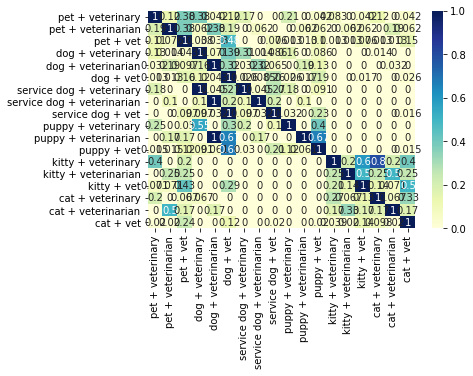

In [45]:
coocc = counts.T.dot(counts)
cooccurrence_matrix_diagonal = np.diagonal(coocc)
with np.errstate(divide='ignore', invalid='ignore'):
    cooccurrence_matrix_percentage = np.nan_to_num(np.true_divide(coocc, cooccurrence_matrix_diagonal[:, None]))

coocc_p = pd.DataFrame(cooccurrence_matrix_percentage)
coocc_p.columns = counts.columns
coocc_p.index = counts.columns
sns.heatmap(coocc_p, cmap="YlGnBu", annot=True)

In [75]:
feed.reset_index(drop=True, inplace=True)
counts.reset_index(drop=True, inplace=True)

In [76]:
merged = pd.concat([feed, counts], axis=1)

In [77]:
merged['counts_sum'] = counts_sum

In [78]:
merged = merged[merged['counts_sum'] > 0]

In [79]:
#merged.to_csv("vet_check_1.csv", index=False)

In [150]:
results = []
for index, row in merged.iloc[300:,].iterrows():
    doc = '''
    
    [[AdvancedFormat]]
    
    [[Question:MC:SingleAnswer:Vertical]]
    [[ID:{0}]]
    {1}
    [[Choices]]
    True Positive
    False Positive
    
    [[PageBreak]]


    '''.format(row['url'],row['fund_description'])
    results.append(doc)
doc = "\n".join(results)
with open("vet_survey_1.txt", "w") as text_file:
    text_file.write(doc)

### Excluding non-English campaigns

In [3]:
conn = sqlite3.connect("gfm.db")
feed = pd.read_sql_query("SELECT * FROM feed_tb", conn)
feed = feed.drop_duplicates('url')

In [3]:
feed['fund_description'] = [' '.join(BeautifulSoup(x).findAll(text=True)).replace(u'\xa0', u' ') for x in feed['fund_description']]
feed['fund_description'] = [x.replace('\n','') for x in feed['fund_description']]

/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning: "b'/'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [4]:
feed = feed.drop_duplicates('url')
feed['fund_description'] = [' '.join(BeautifulSoup(x).findAll(text=True)).replace(u'\xa0', u' ') for x in feed['fund_description']]
#feed['fund_description'] = feed['fund_description'].str.lower()
feed['fund_description'] = [x.replace('\n','') for x in feed['fund_description']]
feed['nchar']= [len(x) for x in feed['fund_description']]
feed = feed[feed['nchar'] >= 100]

/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning: "b'/'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [5]:
def GetLanguage(df):
    path_to_pretrained_model = 'fasttext_models/lid.176.bin'
    fmodel = fasttext.load_model(path_to_pretrained_model)
    r = fmodel.predict(feed['fund_description'].to_list())
    labels = r[0]
    labels = [i[0].split('__')[2] for i in labels]
    scores = r[1]
    scores = [i[0] for i in scores]
    return labels, scores

In [6]:
feed['language'], feed['lang_score'] = GetLanguage(feed)

In [7]:
feed = feed[feed['language'] == 'en']

In [8]:
len(feed)

89506

### Super earners

In [9]:
feed['url'].nunique()

89506

In [10]:
len(feed[(feed['current_amount'] < 100_000) & (feed['current_amount'] > 50_000)])

685

In [11]:
feed['current_amount'].quantile([.1,.5,.6,.7,.8,.9,.95,.995])

0.100      785.00
0.500     3310.00
0.600     4300.00
0.700     5730.00
0.800     8255.00
0.900    13760.00
0.950    21358.50
0.995    64604.25
Name: current_amount, dtype: float64

In [12]:
feed[feed['current_amount'] > 100_000]['donation_count'].describe()

count      157.000000
mean      2180.656051
std       3381.199115
min          8.000000
25%        752.000000
50%       1321.000000
75%       2140.000000
max      25561.000000
Name: donation_count, dtype: float64

In [13]:
feed['earner_category'] = np.where(feed['current_amount'] > 100_000, 'se', 'non_se')

In [14]:
se = feed[feed['earner_category'] == 'se']

In [15]:
non_se = feed[feed['earner_category'] == 'non_se']

### How much do super earners ask for?

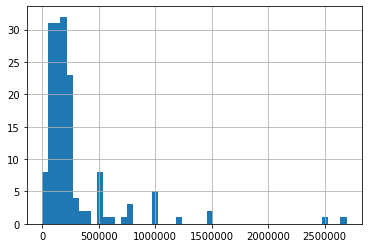

In [16]:
se['goal_amount'].hist(bins=50)

In [17]:
se['goal_amount'].quantile([0,.25,.5,.75, 1])

0.00        100.0
0.25     110000.0
0.50     187000.0
0.75     250000.0
1.00    2695000.0
Name: goal_amount, dtype: float64

### Control group # 1: Super earner fails

- First, we will assign super earners to a goal amount quartile
- Second, we will randomly sample 1x campaigns in that goal amount quartile who make < 100_000 and start within 6 months of corresponding super earner

In [18]:
se['quart'] = pd.qcut(se['goal_amount'], 4, labels=False)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
from copy import deepcopy
from dateutil.relativedelta import relativedelta

In [20]:
def GetControl1(se, non_se):
    #define results container to store urls of control campaigns
    r = []
    #define copy of non_se pool
    non_se_copy = deepcopy(non_se)
    #ensure dates are properly formatted
    se['launch_date'] = pd.to_datetime(se['launch_date'], utc=True)  
    non_se_copy['launch_date'] = pd.to_datetime(non_se_copy['launch_date'], utc=True) 
    #loop through SE campaigns, sample
    for index, row in se.iterrows():
        quart = row['quart']
        date = row['launch_date']
        #get subset of candidate campaigns based on goal amount quartile
        if quart == 0:
            cand = non_se_copy[(non_se_copy['goal_amount'] > 100) & (non_se_copy['goal_amount'] <= 110000)]
        elif quart == 1:
            cand = non_se_copy[(non_se_copy['goal_amount'] > 110000) & (non_se_copy['goal_amount'] <= 187000)]
        elif quart == 2:
            cand = non_se_copy[(non_se_copy['goal_amount'] > 187000) & (non_se_copy['goal_amount'] <= 250000)]
        elif quart == 3:
            cand = non_se_copy[(non_se_copy['goal_amount'] > 250000) & (non_se_copy['goal_amount'] <= 2695000)]
        #subset candidate campaigns based on launch date
        six_mo_before = date + relativedelta(months=-3)
        six_mo_after = date + relativedelta(months=+3)
        date_mask = (cand['launch_date'] >= six_mo_before) & (cand['launch_date'] <= six_mo_after)
        cand = cand.loc[date_mask]
        if len(cand) < 2:
            print('no candidates for {0}'.format(row['url']))
            continue
        #sample candidate campaigns 1:1
        cand = cand.sample(1)
        #store urls in results container
        [r.append(url) for url in cand['url'].tolist()]
        #remove urls in results from candidate pool
        non_se_copy = non_se_copy[~non_se_copy['url'].isin(r)]

    return r

In [24]:
con_1_urls = GetControl1(se, non_se)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [25]:
con_1 = non_se[non_se['url'].isin(con_1_urls)]

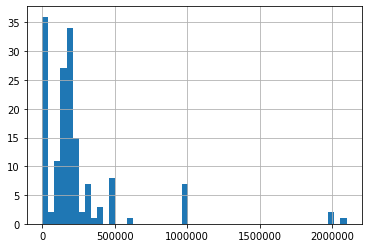

In [26]:
con_1['goal_amount'].hist(bins=50)

### Control group # 2: Average campaign
- we will randomly sample 1x remaining campaigns that start within 6 months of corresponding super earner

In [27]:
def GetControl2(se, non_se):
    #define results container to store urls of control campaigns
    r = []
    #define copy of non_se pool
    non_se_copy = deepcopy(non_se)
    #ensure dates are properly formatted
    se['launch_date'] = pd.to_datetime(se['launch_date'], utc=True)  
    non_se_copy['launch_date'] = pd.to_datetime(non_se_copy['launch_date'], utc=True) 
    #loop through SE campaigns, sample
    for index, row in se.iterrows():
        date = row['launch_date']
        #subset candidate campaigns based on launch date
        six_mo_before = date + relativedelta(months=-3)
        six_mo_after = date + relativedelta(months=+3)
        cand = non_se_copy
        date_mask = (cand['launch_date'] >= six_mo_before) & (cand['launch_date'] <= six_mo_after)
        cand = cand.loc[date_mask]
        if len(cand) < 2:
            print('no candidates for {0}'.format(row['url']))
            continue
        #sample candidate campaigns 1:1
        cand = cand.sample(1)
        #store urls in results container
        [r.append(url) for url in cand['url'].tolist()]
        #remove urls in results from candidate pool
        non_se_copy = non_se_copy[~non_se_copy['url'].isin(r)]

    return r

In [28]:
con_2_urls = GetControl2(se, non_se[~non_se['url'].isin(con_1['url'].tolist())])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [31]:
con_2 = non_se[non_se['url'].isin(con_2_urls)]

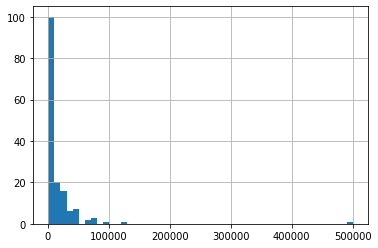

In [32]:
con_2['goal_amount'].hist(bins=50)

### Plot together

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Text(0, 0.5, 'Frequency')

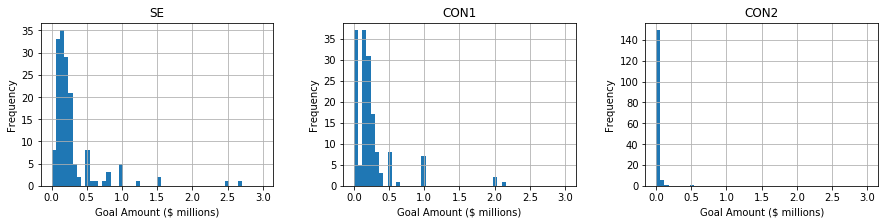

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15,3))

se['goal_amount_div'] = se['goal_amount']/1000000
con_1['goal_amount_div'] = con_1['goal_amount']/1000000
con_2['goal_amount_div'] = con_2['goal_amount']/1000000

se.hist('goal_amount_div', bins=50, ax=axes[0], range=[0, 3])
con_1.hist('goal_amount_div', bins=50, ax=axes[1], range=[0, 3])
con_2.hist('goal_amount_div', bins=50, ax=axes[2], range=[0, 3])

axes[0].set_title('SE')
axes[1].set_title('CON1')
axes[2].set_title('CON2')

axes[0].set_xlabel("Goal Amount ($ millions)")
axes[1].set_xlabel("Goal Amount ($ millions)")
axes[2].set_xlabel("Goal Amount ($ millions)")

axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[2].set_ylabel("Frequency")

### Prepare data for export

In [38]:
se.loc[:,'group'] = ['super_earner' for x in range(len(se))]
con_1.loc[:,'group'] = ['con_1' for x in range(len(con_1))]
con_2.loc[:,'group'] = ['con_2' for x in range(len(con_2))]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [39]:
print(se.shape)
print(con_1.shape)
print(con_2.shape)

(157, 73)
(157, 72)
(157, 72)


In [41]:
df = pd.concat([se, con_1, con_2])

In [42]:
df = df[['url','fund_name','fund_description','group']]

In [44]:
df.to_csv('Super earners/Ada/super_earner_data.csv', index=False)

In [46]:
feed['url'][feed['url'].str.contains('lets-kick-cancer-in')][10158]

'https://www.gofundme.com/f/lets-kick-cancer-in-the'

### Exploratory data analysis

In [8]:
feed['year'].value_counts().sort_index()

2010        6
2011       32
2012      133
2013     1054
2014     8161
2015    20486
2016    15123
2017    10488
2018    11632
2019    16468
2020    16360
Name: year, dtype: int64

In [12]:
feed = feed[feed.goal_amount < feed.goal_amount.quantile(.99)]

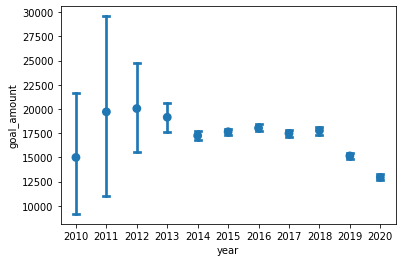

In [13]:
sns.pointplot(data=feed, x='year', y='goal_amount', join=False, capsize=0.2)

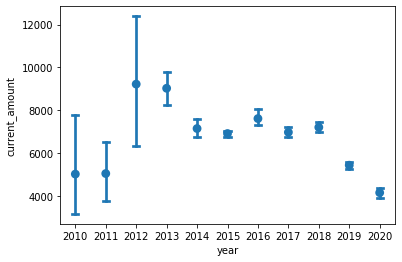

In [10]:
sns.pointplot(data=feed, x='year', y='current_amount', join=False, capsize=0.2)

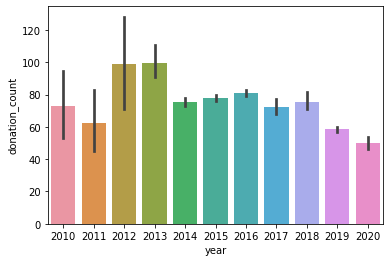

In [13]:
sns.barplot(data=feed, x='year', y='donation_count')

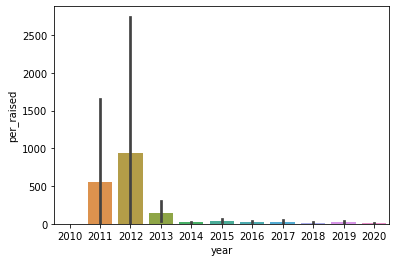

In [18]:
sns.barplot(data=feed, x='year', y='per_raised')

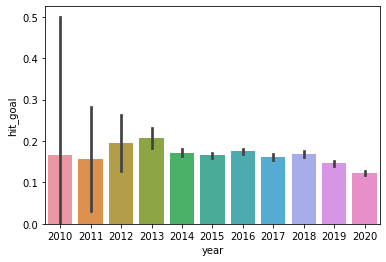

In [21]:
sns.barplot(data=feed, x='year', y='hit_goal')

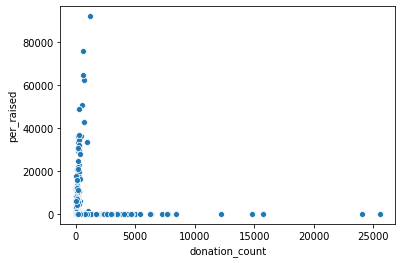

In [26]:
sns.scatterplot(data=feed, x='donation_count', y='per_raised')

In [29]:
feed['per_raised'].describe()

count    99943.000000
mean        27.305981
std        806.788960
min          0.000000
25%          0.189700
50%          0.431000
75%          0.794000
max      92013.000000
Name: per_raised, dtype: float64

In [30]:
feed = feed[feed.per_raised < feed.per_raised.quantile(.95)]

In [31]:
feed['per_raised'].describe()

count    94945.000000
mean         0.472191
std          0.343757
min          0.000000
25%          0.180000
50%          0.402500
75%          0.730000
max          1.360500
Name: per_raised, dtype: float64

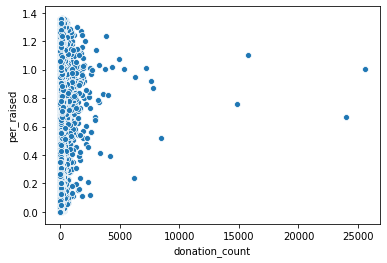

In [32]:
sns.scatterplot(data=feed, x='donation_count', y='per_raised')

In [33]:
feed = feed[feed.donation_count < feed.donation_count.quantile(.95)]

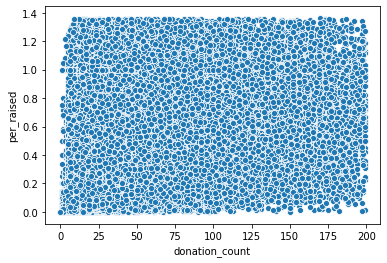

In [34]:
sns.scatterplot(data=feed, x='donation_count', y='per_raised')

In [35]:
feed['donation_count'].describe()

count    90156.000000
mean        48.749334
std         39.981108
min          0.000000
25%         21.000000
50%         37.000000
75%         65.000000
max        199.000000
Name: donation_count, dtype: float64

In [39]:
sum(sum([feed['donation_count'] == 0]))

1989